## Topic Segmentation

### Fetching and preprocessing tweets

In [1]:
# Add project path to the PYTHONPATH

import os
import sys
from pathlib import Path

sys.path.append(Path(os.path.join(os.path.abspath(''), '../')).resolve().as_posix())

In [2]:
from nlp.dataset import Dataset

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/matheus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
filename = '../datasets/topic_segmentation/1183377763962671104-1182876466129887233_nobel.csv'
dataset = Dataset(filename, label_col='label', text_col='text')
dataset.load()
dataset.preprocess_texts(stemming=True, no_emoji=True)

Time to clean up: 3.89 sec


In [4]:
df = dataset.dataframe
df.cleaned.head()

0    pm abiy ahmed not exercising power control dis...
1                            cares fact received nobel
2    lithium ion batteries work earns nobel prize c...
3    congratulations nobel committee gave literatur...
4                 wow know obama nobel peace prize win
Name: cleaned, dtype: object

In [5]:
preprocessed_tweets = [tweet.split() for tweet in df.cleaned]
preprocessed_tweets[1:2]

[['cares', 'fact', 'received', 'nobel']]

In [6]:
import gensim

In [7]:
%%time
dictionary = gensim.corpora.Dictionary(preprocessed_tweets)
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)
bow_corpus = [dictionary.doc2bow(tweets) for tweets in preprocessed_tweets]

CPU times: user 273 ms, sys: 8.04 ms, total: 281 ms
Wall time: 281 ms


In [8]:
document_num = 0
bow_doc_x = bow_corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Word 0 ("ahmed") appears 1 time.
Word 1 ("aung") appears 1 time.
Word 2 ("control") appears 1 time.
Word 3 ("democracy") appears 1 time.
Word 4 ("like") appears 1 time.
Word 5 ("party") appears 1 time.
Word 6 ("pm") appears 1 time.
Word 7 ("power") appears 1 time.
Word 8 ("san") appears 1 time.
Word 9 ("suu") appears 1 time.
Word 10 ("winner") appears 1 time.


### Coherence model

In [9]:
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

In [10]:
%%time
num_topics_values = range(4, 16)
models = []
coherence_values = {
    'u_mass': [],
    'c_v': [],
    'c_uci': [],
    'c_npmi': []
}

for num_topics in num_topics_values:
    model = gensim.models.LdaMulticore(bow_corpus, 
                                       num_topics=num_topics, 
                                       id2word=dictionary,                                    
                                       passes=20,
                                       workers=5,
                                       iterations=400)
    models.append(model)
        
    u_mass_coherence_model = CoherenceModel(model=model, corpus=bow_corpus, texts=preprocessed_tweets, coherence='u_mass')
    coherence_values['u_mass'].append(u_mass_coherence_model.get_coherence())

    c_v_coherence_model = CoherenceModel(model=model, corpus=bow_corpus, texts=preprocessed_tweets, coherence='c_v')
    coherence_values['c_v'].append(c_v_coherence_model.get_coherence())
    
    c_uci_coherence_model = CoherenceModel(model=model, corpus=bow_corpus, texts=preprocessed_tweets, coherence='c_uci')
    coherence_values['c_uci'].append(c_uci_coherence_model.get_coherence())
    
    c_npmi_coherence_model = CoherenceModel(model=model, corpus=bow_corpus, texts=preprocessed_tweets, coherence='c_npmi')
    coherence_values['c_npmi'].append(c_npmi_coherence_model.get_coherence())

CPU times: user 4min 27s, sys: 17.7 s, total: 4min 45s
Wall time: 4min 35s


### Graph plotting

In [11]:
import matplotlib.pyplot as plt
import numpy as np

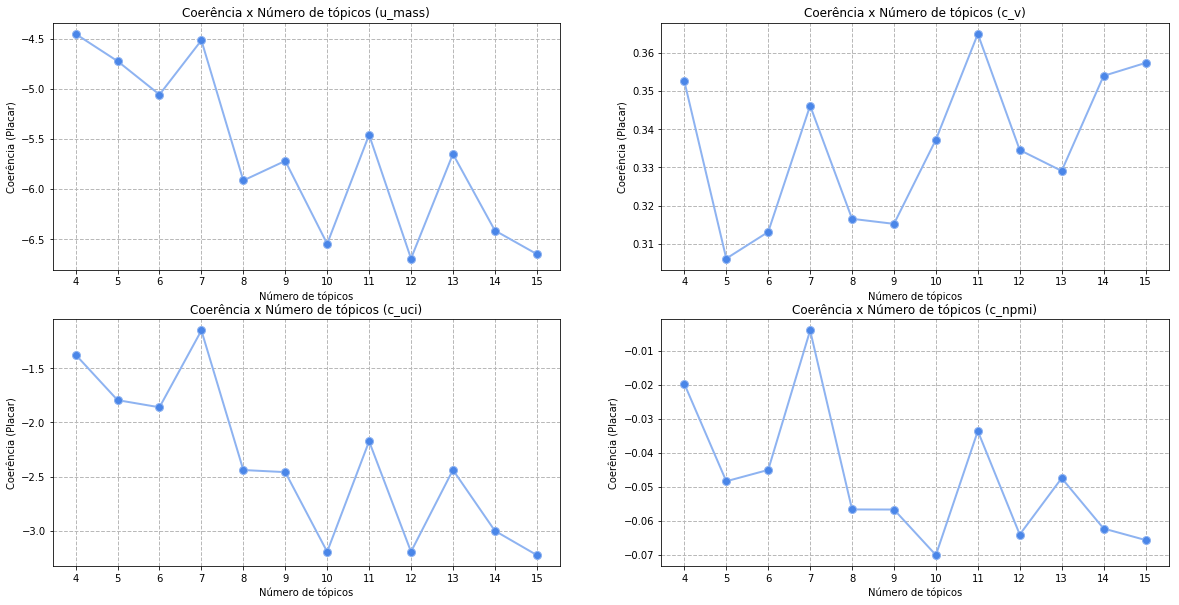

In [20]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.xticks(np.arange(min(num_topics_values), max(num_topics_values)+1, 1.0))
plt.plot(num_topics_values, coherence_values['u_mass'], color='#8eb3f1', linestyle='solid', linewidth = 2, 
         marker='o', markerfacecolor='#4a86e8', markersize=8) 
plt.title('Coerência x Número de tópicos (u_mass)') 
plt.rc('grid', linestyle='dashed', linewidth=1, color='#b9b9b9')
plt.grid()
plt.ylabel('Coerência (Placar)') 
plt.xlabel('Número de tópicos') 

plt.subplot(2,2,2)
plt.xticks(np.arange(min(num_topics_values), max(num_topics_values)+1, 1.0))
plt.plot(num_topics_values, coherence_values['c_v'], color='#8eb3f1', linestyle='solid', linewidth = 2, 
         marker='o', markerfacecolor='#4a86e8', markersize=8) 
plt.title('Coerência x Número de tópicos (c_v)') 
plt.rc('grid', linestyle='dashed', linewidth=1, color='#b9b9b9')
plt.grid()
plt.ylabel('Coerência (Placar)') 
plt.xlabel('Número de tópicos') 

plt.subplot(2,2,3)
plt.xticks(np.arange(min(num_topics_values), max(num_topics_values)+1, 1.0))
plt.plot(num_topics_values, coherence_values['c_uci'], color='#8eb3f1', linestyle='solid', linewidth = 2, 
         marker='o', markerfacecolor='#4a86e8', markersize=8) 
plt.title('Coerência x Número de tópicos (c_uci)') 
plt.rc('grid', linestyle='dashed', linewidth=1, color='#b9b9b9')
plt.grid()
plt.ylabel('Coerência (Placar)') 
plt.xlabel('Número de tópicos') 

plt.subplot(2,2,4)
plt.xticks(np.arange(min(num_topics_values), max(num_topics_values)+1, 1.0))
plt.plot(num_topics_values, coherence_values['c_npmi'], color='#8eb3f1', linestyle='solid', linewidth = 2, 
         marker='o', markerfacecolor='#4a86e8', markersize=8) 
plt.title('Coerência x Número de tópicos (c_npmi)') 
plt.rc('grid', linestyle='dashed', linewidth=1, color='#b9b9b9')
plt.grid()
plt.ylabel('Coerência (Placar)') 
plt.xlabel('Número de tópicos') 


plt.show() 

### Model visualization

In [15]:
import pyLDAvis.gensim

In [25]:
pyLDAvis.enable_notebook()

pyLDAvis.gensim.prepare(models[3], bow_corpus, dictionary, sort_topics=False)

/home/matheus/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.060153  0.161965       1        1  12.389250
1     -0.107054 -0.133427       2        1  15.323334
2      0.075194  0.221667       3        1  10.084080
3      0.339093 -0.108616       4        1  15.630256
4     -0.118702 -0.095132       5        1  18.587931
5     -0.056751  0.067329       6        1  15.270901
6     -0.071628 -0.113786       7        1  12.714249, topic_info=    Category         Freq             Term        Total  loglift  logprob
0    Default  1175.000000            ahmed  1175.000000  30.0000  30.0000
149  Default   904.000000         ethiopia   904.000000  29.0000  29.0000
135  Default   798.000000            prime   798.000000  28.0000  28.0000
50   Default   888.000000            greta   888.000000  27.0000  27.0000
133  Default   754.000000         minister   754.000000  26.0000  26.0000
132  Default   749.000000        ethiopian   749.000000  25.0000  25.0000
52   Default   524.000000         thunberg   524.000000  24.0000  24.0000
25   Default   548.000000       literature   548.000000  23.0000  23.0000
6    Default   535.000000               pm   535.000000  22.0000  22.0000
397  Default   403.000000             wins   403.000000  21.0000  21.0000
148  Default   364.000000          eritrea   364.000000  20.0000  20.0000
15   Default   270.000000        chemistry   270.000000  19.0000  19.0000
24   Default   271.000000         genocide   271.000000  18.0000  18.0000
324  Default   398.000000           handke   398.000000  17.0000  17.0000
106  Default   543.000000               no   543.000000  16.0000  16.0000
22   Default   371.000000  congratulations   371.000000  15.0000  15.0000
19   Default   599.000000             work   599.000000  14.0000  14.0000
915  Default   306.000000            price   306.000000  13.0000  13.0000
44   Default   237.000000        rejection   237.000000  12.0000  12.0000
41   Default   349.000000            peter   349.000000  11.0000  11.0000
28   Default   819.000000              win   819.000000  10.0000  10.0000
27   Default   435.000000            obama   435.000000   9.0000   9.0000
287  Default   221.000000              ali   221.000000   8.0000   8.0000
47   Default   213.000000           letter   213.000000   7.0000   7.0000
16   Default   163.000000              ion   163.000000   6.0000   6.0000
232  Default   281.000000          climate   281.000000   5.0000   5.0000
94   Default   583.000000           people   583.000000   4.0000   4.0000
197  Default   543.000000              via   543.000000   3.0000   3.0000
17   Default   147.000000          lithium   147.000000   2.0000   2.0000
120  Default   736.000000          awarded   736.000000   1.0000   1.0000
..       ...          ...              ...          ...      ...      ...
486   Topic7    79.778015             help    95.600105   1.8815  -4.9519
192   Topic7   150.439606          physics   205.869186   1.7488  -4.3176
232   Topic7   188.689224          climate   281.288879   1.6632  -4.0911
231   Topic7    79.608955             call   106.082748   1.7754  -4.9541
400   Topic7    37.637615            mayor    43.150356   1.9258  -5.7032
807   Topic7    47.156609             face    58.874664   1.8405  -5.4777
648   Topic7    64.024170             lost    95.999428   1.6574  -5.1719
525   Topic7    87.365829            right   167.065857   1.4142  -4.8611
28    Topic7   230.614182              win   819.605103   0.7944  -3.8904
197   Topic7   167.969879              via   543.203857   0.8887  -4.2074
229   Topic7    57.418327            thank    93.378662   1.5761  -5.2808
66    Topic7   129.198029            trump   392.699066   0.9507  -4.4698
856   Topic7    50.001419           around    75.757957   1.6470  -5.4191
55    Topic7    68.007256          another   137.495377   1.3585  -5.1116
276   Topic7    61.501507          snubbed   118.356888   1.4078  -